In [39]:
import numpy as np
import torch
import random
import os
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

Matplotlib created a temporary cache directory at /tmp/matplotlib-qh474h1n because the default path (/home/weihsin/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [14]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(123)

Random seed set as 123


## Task Definition
You are given a matrix $X \in \mathbb{R}^{N\times d}$, where a specific row $i$ is filled with 0.5 + 0.1*$\epsilon$ vector, where $\epsilon \sim Uniform(0,1)$. <br>
Your goal is to build a deep learning model to predict which row $i$ is the corresponding target row.


## Data Preparation

In [15]:
input_dim = 5
num_data = 50

def sample_single_data(num_samples: int, target_row: int):
    '''
    create single data.
    Args:
        num_samples: number of rows of the matrix
        target_row: the target row with all -1 vector
    Return:
        X: output matrix
        target_row: label
    '''
    X = np.random.uniform(size=(num_samples, input_dim))
    X[target_row, :] = 0.5 + 0.1*np.random.uniform(size=input_dim) 
    X = torch.FloatTensor(X)
    
    return X, target_row

def sample_batch(batch_size):
    '''
    create batch training data.
    Args:
        batch_size: the number of batches of a training data
    Return:
        batch_x: batch of matrix, shape = (batch, num_data, input_dim)
        batch_y: label, shape = (batch)
    '''
    batch_x = []
    batch_y = []
    for _ in range(batch_size):
        target_row = np.random.randint(num_data)
        X,Y = sample_single_data(num_data, target_row)
        batch_x.append(X.unsqueeze(0))
        batch_y.append(Y)
    batch_x = torch.cat(batch_x,dim=0)
    batch_y = torch.LongTensor(batch_y)
    
    return batch_x, batch_y

def evaluate(prediction, target):
    accuracy = prediction.eq(target).float().mean()
    return accuracy

In [16]:
## sample one data for visualization
x, y = sample_batch(5)
print(x.shape)
print(y.shape)
print(x[1])
print(x[1][y])

torch.Size([5, 50, 5])
torch.Size([5])
tensor([[6.8362e-01, 9.4662e-01, 9.1323e-01, 5.1255e-02, 3.8032e-01],
        [5.6386e-01, 1.3257e-01, 5.7514e-01, 3.2257e-01, 9.8393e-01],
        [5.7567e-01, 6.2973e-01, 4.0101e-01, 7.4463e-01, 4.0119e-01],
        [7.6548e-01, 9.8243e-01, 1.6812e-01, 4.7459e-01, 5.4894e-01],
        [4.3611e-01, 2.9673e-01, 3.9356e-01, 8.3808e-01, 6.5164e-01],
        [9.5390e-01, 4.7700e-01, 8.7889e-01, 7.9221e-01, 2.6536e-01],
        [7.6244e-01, 8.2274e-01, 3.5299e-01, 9.7423e-01, 6.7523e-01],
        [6.9938e-01, 4.5960e-01, 6.9735e-02, 9.9798e-01, 6.3775e-01],
        [6.8153e-02, 1.4614e-01, 8.3891e-01, 2.7719e-01, 5.3945e-01],
        [8.0433e-02, 5.6635e-01, 3.6248e-01, 3.1821e-01, 6.5352e-01],
        [3.5490e-01, 7.1526e-01, 6.2828e-01, 9.6751e-01, 2.8142e-01],
        [2.4640e-01, 7.7518e-02, 8.9208e-01, 3.4545e-02, 4.9148e-01],
        [9.0456e-04, 8.8920e-01, 3.3940e-01, 6.3082e-01, 3.3071e-01],
        [8.8899e-01, 7.2932e-01, 9.4321e-02, 7.0670

In [17]:
# evaluation
print("Target:",y)
prediction = torch.LongTensor([17,  8, 20, 46, 17])
accuracy = evaluate(prediction, y)
print(f"Accuracy: {accuracy:.4f}")

Target: tensor([45, 48, 35, 17, 49])
Accuracy: 0.0000


## Define your model

In [31]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.net = nn.Sequential(
        nn.Linear(5, 48),
        nn.ReLU(),
        nn.Linear(48, 120),
        nn.ReLU(),
        nn.Linear(120, 240),
        nn.ReLU(),
        nn.Linear(240, 48),
        nn.ReLU(),
        nn.Linear(48, 1)
    )
        
        
    def forward(self, inputs):
        outputs = self.net(inputs)
        outputs = outputs.squeeze(-1)
        return outputs
      

## Training and evaluate

3.9134631156921387
3.91233229637146
3.9111595153808594
3.9101157188415527
3.909550666809082
3.908560037612915
3.9079012870788574
3.9072024822235107
3.9063940048217773
3.9053211212158203
Acc:  0.5019
3.9044055938720703
3.9037280082702637
3.903108835220337
3.9024622440338135
3.9018940925598145
3.9011600017547607
3.900813341140747
3.900078535079956
3.8994784355163574
3.898707628250122
Acc:  0.9162
3.897954225540161
3.897606372833252
3.896739959716797
3.8962314128875732
3.895301342010498
3.89461612701416
3.8937742710113525
3.893280029296875
3.892310619354248
3.8915657997131348
Acc:  0.9862
3.890711545944214
3.890049695968628
3.889178514480591
3.8877944946289062
3.8878209590911865
3.885981321334839
3.8854775428771973
3.884657859802246
3.883613109588623
3.882098436355591
Acc:  0.9944
3.8815338611602783
3.8804895877838135
3.879563093185425
3.8786697387695312
3.877218246459961
3.8757433891296387
3.8753483295440674
3.8740599155426025
3.871675729751587
3.8705713748931885
Acc:  0.9969
3.870142698

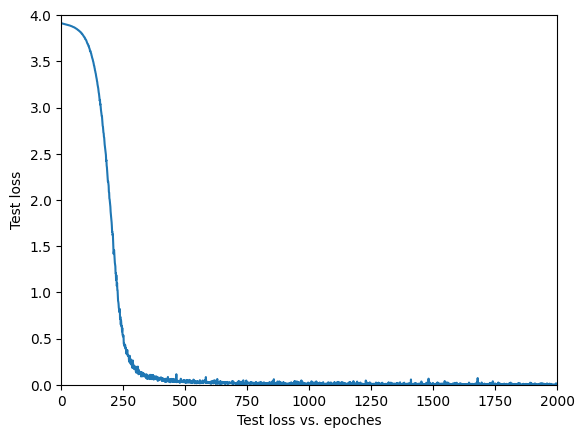

In [73]:
#定義兩個數組
Loss_list = []
Accuracy_list = []

model = MyModel()
param_groups = [
    {'params': model.parameters(), 'lr': 0.0001,'lr_mult':0.1},

]
optimizer =  torch.optim.Adam(param_groups)
loss_function = nn.CrossEntropyLoss()
num = 2000
num_epochs = range(num)
num_accur = num//10
num_epochs_accur = range(num_accur)
training_batch_size = 32
testing_data = sample_batch(1600)

for epoch in num_epochs:
    # sample training data
    x,y = sample_batch(training_batch_size) 

    predictions = model(x)  
   
    loss = loss_function(predictions, y)
    # 畫圖
    print(loss.item())
    Loss_list.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        x, y = testing_data # 1600*50*5
        predictions = model(x)
        predictions = torch.argmax(predictions, dim=1)
        acc = evaluate(predictions, y)
        Accuracy_list.append(acc )
        print(f"Acc: {acc.item(): .4f}")

#我這裏迭代了200次，所以x的取值範圍爲(0，200)，然後再將每次相對應的準確率以及損失率附在x上
x1 = num_epochs_accur
x2 = num_epochs
y1 = Accuracy_list
y2 = Loss_list
plt.xlim(0,num_accur)
plt.ylim(0,1)

plt.plot(x1, y1)
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.savefig("accuracy.jpg")

plt.cla()
plt.xlim(0,num)
plt.ylim(0,4)

plt.plot(x2, y2)
plt.xlabel('Test loss vs. epoches')
plt.ylabel('Test loss')
plt.savefig("loss.jpg")